In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Softmax, Softmax, Dropout

## 1.Data Collection

In [3]:
import tensorflow_datasets as tfds

radon, info = tfds.load('radon', with_info=True, split='train')

df = tfds.as_dataframe(radon, info)

for col, dtype in df.dtypes.items():
    if dtype == np.object:  # Only process byte object columns.
        df[col] = df[col].apply(lambda x: x.decode("utf-8"))

df.rename(columns=lambda x: x.replace('feature/', ""), inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


,activity,features/Uppm,features/adjwt,features/basement,features/cntyfips,features/county,features/dupflag,features/floor,features/idnum,features/lat,...,features/state2,features/stfips,features/stopdt,features/stoptm,features/stratum,features/typebldg,features/wave,features/windoor,features/zip,features/zipflag
0,1.6,2.49759,292.219543,N,3,ALLEN,0,1,1681,41.091000,...,IN,18,11689,2235,2,1,92,,46835,0
1,0.5,2.66527,364.958313,N,25,YAVAPAI,0,1,1457,34.599998,...,AZ,4,22888,1010,2,1,56,,86325,0
2,3.0,2.43343,626.564575,Y,17,MIDDLESEX,0,0,4224,42.485001,...,MA,25,32488,1000,1,1,23,,1778,0
3,0.6,2.43343,570.611755,N,17,MIDDLESEX,0,1,4094,42.485001,...,MA,25,32688,1200,1,1,62,,1432,0
4,1.2,2.10811,426.798859,Y,95,JACKSON,0,0,6849,39.007999,...,MO,29,32488,610,2,1,91,,64134,0


## 2.Data Exploration

In [4]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 12573 entries, 0 to 12572
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   activity           12573 non-null  float32
 1   features/Uppm      12573 non-null  float32
 2   features/adjwt     12573 non-null  float32
 3   features/basement  12573 non-null  object 
 4   features/cntyfips  12573 non-null  int32  
 5   features/county    12573 non-null  object 
 6   features/dupflag   12573 non-null  int32  
 7   features/floor     12573 non-null  int32  
 8   features/idnum     12573 non-null  int32  
 9   features/lat       12573 non-null  float32
 10  features/lon       12573 non-null  float32
 11  features/pcterr    12573 non-null  float32
 12  features/region    12573 non-null  int32  
 13  features/rep       12573 non-null  int32  
 14  features/room      12573 non-null  int32  
 15  features/startdt   12573 non-null  int32  
 

In [5]:
# ทำการลบ feature ที่ไม่จำเป็นทิ้ง
df.drop(columns=[
    'features/state', 'features/state2', 'features/stfips', 'features/zip', 'features/lat', 'features/lon', 'features/idnum', 'features/region',
    #'features/starttm', 'features/stoptm', 'features/startdt', 'features/stopdt', 'features/county',
    'features/zipflag', 'features/cntyfips', 'features/windoor', # windoor: all record's null
    'features/basement', 
    'features/typebldg', 'features/dupflag', 'features/room'
    ], inplace=True)

In [6]:
print('number of rows: ' + str(df.shape[0] ))
print('number of features: ' + str(df.shape[1]))

number of rows: 12573
number of features: 13


In [7]:
df.columns

Index(['activity', 'features/Uppm', 'features/adjwt', 'features/county',
       'features/floor', 'features/pcterr', 'features/rep', 'features/startdt',
       'features/starttm', 'features/stopdt', 'features/stoptm',
       'features/stratum', 'features/wave'],
      dtype='object')

In [8]:
df.head()

,activity,features/Uppm,features/adjwt,features/county,features/floor,features/pcterr,features/rep,features/startdt,features/starttm,features/stopdt,features/stoptm,features/stratum,features/wave
0,1.6,2.49759,292.219543,ALLEN,1,12.7,3,11489,2230,11689,2235,2,92
1,0.5,2.66527,364.958313,YAVAPAI,1,0.0,5,22688,833,22888,1010,2,56
2,3.0,2.43343,626.564575,MIDDLESEX,0,9.7,1,32288,1000,32488,1000,1,23
3,0.6,2.43343,570.611755,MIDDLESEX,1,27.6,3,32488,700,32688,1200,1,62
4,1.2,2.10811,426.798859,JACKSON,0,23.5,3,32288,605,32488,610,2,91


In [9]:
# ทำการแปลงค่า Uppm และ acticity ที่มีค่าเป็น 0 ให้เป็น 0.1 ก่อนนำไป take log เพื่อป้องกันกรณีเกิด undefine value (infinity)
df['activity'] = df['activity'].apply(lambda x: x if x > 0. else 0.1)
df['features/Uppm'] = df['features/Uppm'].apply(lambda x: x if x > 0. else 0.1)
df['log/activity'] = df['activity'].apply(np.log)
df['log/Uppm'] = df['features/Uppm'].apply(np.log)

In [10]:
#df.loc[(df['features/starttm'] >= 0) & (df['features/starttm'] <= 10), ['features/starttm', 'features/stoptm']]
#df.loc[(df['features/starttm'] >= 0) & (df['features/starttm'] <= 200), ['features/starttm', 'features/stoptm']]

In [11]:
# ทำการลบ features/starttm และ features/stoptm เนื่องจากมีบางค่าที่ starttm = 0 and stopttm = 0 ซึ่งไม่สมเหตุสมผลและ date format ไม่เหมือน HHMM
df.drop(columns=['features/stoptm', 'features/starttm'], inplace=True)

### Feature Engineering

In [12]:
df[df['features/startdt'] <= 100000]
# minimum character lenth = 5

,activity,features/Uppm,features/adjwt,features/county,features/floor,features/pcterr,features/rep,features/startdt,features/stopdt,features/stratum,features/wave,log/activity,log/Uppm
0,1.600000,2.49759,292.219543,ALLEN,1,12.7,3,11489,11689,2,92,0.470004,0.915326
1,0.500000,2.66527,364.958313,YAVAPAI,1,0.0,5,22688,22888,2,56,-0.693147,0.980305
2,3.000000,2.43343,626.564575,MIDDLESEX,0,9.7,1,32288,32488,1,23,1.098612,0.889302
3,0.600000,2.43343,570.611755,MIDDLESEX,1,27.6,3,32488,32688,1,62,-0.510826,0.889302
4,1.200000,2.10811,426.798859,JACKSON,0,23.5,3,32288,32488,2,91,0.182322,0.745792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,66.599998,2.67972,1065.307129,LANCASTER,0,1.4,4,21489,21689,4,110,4.198705,0.985712
12569,5.500000,3.28000,1074.013672,PHILADELPHIA,0,7.1,2,41188,41388,4,40,1.704748,1.187843
12570,3.800000,1.54905,218.337860,BURLEIGH,0,6.0,4,30388,30388,5,64,1.335001,0.437642
12571,3.700000,2.92643,2364.762695,MONTGOMERY,0,6.2,1,12889,13089,5,88,1.308333,1.073783


In [13]:
df[['features/startdt', 'features/stopdt']]
# จาก date format ของ features/startdt และ features/stopdt ที่เป็น MMHHYY และจากผลลัพธ์ด้านล่าง 
# ที่มี data length 5 หรือ 6 จะได้ว่า ตัวที่มี data length = 5 จัวอักษรตัวแรกจะแสดงเดือน ดังนั้นเราจึงเติม 0 เข้าไปข้างหน้า
# เพื่อให้ date format นั้นเท่ากันที่ 6 ตัว เพื่อใช้สำหรับการแปลง

,features/startdt,features/stopdt
0,11489,11689
1,22688,22888
2,32288,32488
3,32488,32688
4,32288,32488
...,...,...
12568,21489,21689
12569,41188,41388
12570,30388,30388
12571,12889,13089


In [14]:
 # ฟังก์ชันในการเติมเลข 0 ข้างหน้า และใส่ 19 ในส่วนของ ค.ศ. เพื่อให้สามารถแปลง data type ได้ตรง format
 def add_zero(col):
     str_col = str(col)
     if len(str_col) == 5:
         year = '19' + str_col[3:]
         str_col = '0' + str_col[0:3] + year
         return str_col
     else:
         year = '19' + str_col[4:]
         str_col = str_col[0:4] + year
         return str_col

In [15]:
# นำ features/startdt และ features/stopdt เข้าฟังก์ชัน add_zero
df['features/startdt'] = df['features/startdt'].apply(add_zero)
df['features/stopdt'] = df['features/stopdt'].apply(add_zero)
# แปลง features/startdt และ features/stopdt เป็น datatype datetime 
df['features/startdt'] = pd.to_datetime(df['features/startdt'], format='%m%d%Y')
df['features/stopdt'] = pd.to_datetime(df['features/stopdt'], format='%m%d%Y')
df.head(7)

,activity,features/Uppm,features/adjwt,features/county,features/floor,features/pcterr,features/rep,features/startdt,features/stopdt,features/stratum,features/wave,log/activity,log/Uppm
0,1.6,2.49759,292.219543,ALLEN,1,12.700000,3,1989-01-14,1989-01-16,2,92,0.470004,0.915326
1,0.5,2.66527,364.958313,YAVAPAI,1,0.000000,5,1988-02-26,1988-02-28,2,56,-0.693147,0.980305
2,3.0,2.43343,626.564575,MIDDLESEX,0,9.700000,1,1988-03-22,1988-03-24,1,23,1.098612,0.889302
3,0.6,2.43343,570.611755,MIDDLESEX,1,27.600000,3,1988-03-24,1988-03-26,1,62,-0.510826,0.889302
4,1.2,2.10811,426.798859,JACKSON,0,23.500000,3,1988-03-22,1988-03-24,2,91,0.182322,0.745792
5,2.8,2.61898,322.107605,BUTLER,0,11.000000,5,1989-02-27,1989-03-03,1,111,1.029619,0.962785
6,1.5,2.14045,211.505112,SCOTT,3,23.299999,1,1988-12-19,1988-12-21,1,8,0.405465,0.761016


In [16]:
# หาจำนวนวันที่ใช้ในการวัดค่า Rn และสร้างเป็น feature ใหม่ชื่อว่า n_datetest
df['n_datetest'] = df['features/stopdt'] - df['features/startdt']
df['n_datetest'].value_counts(dropna=False)
# n_datetest จะเป็น timedelta ดังนั้นเราจะแปลงเป็น int ด้วย days
df['n_datetest'] = df['n_datetest'].dt.days

In [17]:
df[df['n_datetest'] >= 13]

,activity,features/Uppm,features/adjwt,features/county,features/floor,features/pcterr,features/rep,features/startdt,features/stopdt,features/stratum,features/wave,log/activity,log/Uppm,n_datetest
3851,0.1,2.38367,993.154663,GREENE,0,0.0,3,1988-03-26,1999-01-01,4,43,-2.302585,0.868641,3933
5064,0.1,1.96705,579.396851,HAMPDEN,9,0.0,2,1988-03-17,1999-01-01,1,73,-2.302585,0.676535,3942
6169,1.3,2.28582,1060.541626,CAMBRIA,1,22.9,5,1989-01-01,1989-01-14,4,48,0.262364,0.826725,13
9619,0.1,2.01841,120.341354,COCONINO,9,0.0,5,1988-02-11,1999-01-01,1,51,-2.302585,0.702310,3977
10726,0.1,2.56866,1122.880249,ALLEGHENY,9,0.0,1,1989-03-03,1999-01-01,4,115,-2.302585,0.943384,3591
11973,0.1,2.34707,363.432068,COCHISE,9,0.0,2,1988-07-27,1999-01-01,2,122,-2.302585,0.853168,3810


In [18]:
# ลบ record ที่มีค่า n_datetest เกิน 13 เนื่องจากเป็นค่าที่ผิดปกติ
# we'll drop the value that has n_datetest exceed 13
zero_activity = df[df['n_datetest'] > 13].index
df.drop(zero_activity, inplace=True)
df.shape[0]

12568

In [19]:
df['n_datetest'].value_counts(dropna=False)

2     7312
0     2568
3      870
4      397
8      373
7      334
9      238
5      212
10     116
6       73
1       63
11       8
12       3
13       1
Name: n_datetest, dtype: int64

In [20]:
# สร้าง feature ใหม่ชื่อว่า month โดยการ extract เดือนมาจาก features/startdt
df['month'] = df['features/startdt'].dt.month

In [21]:
# drop features 'features/stopdt' และ 'features/startdt'
df.drop(columns=['features/stopdt', 'features/startdt'], inplace=True)

In [22]:
numeric_features = [
    'log/Uppm', 'features/adjwt', 'features/rep', 'features/stratum', 'features/wave', 'features/pcterr', 'n_datetest'
    ]

categorical_features = [
    'features/floor', #'features/basement', 'features/typebldg', 'features/dupflag'
    'features/county'#, 'features/region', 'features/room',
    ,'month' 
    ]

## 3.Data Preparation

### Data Cleansing

#### imputation

In [23]:
# 1 features/dupflag
# df['features/dupflag'].replace({2:0}, inplace=True)
# df['features/dupflag'].value_counts()

In [24]:
# 2 features/typebldg
# df['features/typebldg'].replace({0:1}, inplace=True)
# df['features/typebldg'].value_counts()

In [25]:
# df['features/basement'] = df['features/basement'].astype('str') 

In [26]:
# 4 features/basement
# df['features/basement'].replace({"b' '": "b'Y'"}, inplace=True)
# df['features/basement'].replace({"b'0'": "b'Y'"}, inplace=True)
# df['features/basement'].value_counts()

In [27]:
df['features/floor'].value_counts()

0    8298
1    3949
9     280
2      22
3      19
Name: features/floor, dtype: int64

In [28]:
# แทนค่า floor ที่เท่ากับ 9(unknown) และ 3(ไม่ได้ระบุค่า) ด้วยค่ามัธยฐานซึ่งคือ 0 (basement)
df['features/floor'].replace({9:0, 3:0}, inplace=True)
df['features/floor'].value_counts()

0    8597
1    3949
2      22
Name: features/floor, dtype: int64

#### drop value

In [29]:
# unknown_room = df[df['features/room'] == 0].index
# unknown_room

In [30]:
# df.drop(unknown_room, inplace=True)
# df.shape[0]

### a. Transform Categorical Data
แปลง column ที่ไม่ใช่ตัวเลขด้วย get_dummies

In [31]:
df = pd.get_dummies(df, prefix=None, prefix_sep='_', columns=categorical_features)

In [32]:
df.head()

,activity,features/Uppm,features/adjwt,features/pcterr,features/rep,features/stratum,features/wave,log/activity,log/Uppm,n_datetest,...,month_2,month_3,month_4,month_5,month_6,month_7,month_9,month_10,month_11,month_12
0,1.6,2.49759,292.219543,12.7,3,2,92,0.470004,0.915326,2,...,0,0,0,0,0,0,0,0,0,0
1,0.5,2.66527,364.958313,0.0,5,2,56,-0.693147,0.980305,2,...,1,0,0,0,0,0,0,0,0,0
2,3.0,2.43343,626.564575,9.7,1,1,23,1.098612,0.889302,2,...,0,1,0,0,0,0,0,0,0,0
3,0.6,2.43343,570.611755,27.6,3,1,62,-0.510826,0.889302,2,...,0,1,0,0,0,0,0,0,0,0
4,1.2,2.10811,426.798859,23.5,3,2,91,0.182322,0.745792,2,...,0,1,0,0,0,0,0,0,0,0


### b. Normalize Input Features
Normalize ข้อมูล input features ที่เป็นตัวเลข

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[numeric_features] = scaler.fit_transform(df[numeric_features])

## Modelling
เทรนโมเดลโดยการแบ่ง train (7,000 ตัว), validation (3,000 ตัว) และ test set (ข้อมูลที่เหลือ)

In [224]:
def build_model():
  model = models.Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],), kernel_initializer='he_normal'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
  return model

### c.

In [402]:
X = df.drop(columns=['log/activity', 'activity', 'features/Uppm'])
y = df['log/activity']
X = X[0:10000]
y = y[0:10000]

In [403]:
X = df.drop(columns=['log/activity', 'activity', 'features/Uppm'])
y = df['log/activity']
Xtest = X[10000:]
ytest = y[10000:]

In [227]:
# build the model
tf.random.set_seed(46)

model = build_model()

model.summary()

Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_564 (Dense)           (None, 64)                26112     
                                                                 
 dense_565 (Dense)           (None, 64)                4160      
                                                                 
 dense_566 (Dense)           (None, 1)                 65        
                                                                 
Total params: 30,337
Trainable params: 30,337
Non-trainable params: 0
_________________________________________________________________


In [228]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_cb = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)

In [229]:
history = model.fit(X, y, validation_split = 0.3, epochs=100, batch_size=16, callbacks=[early_stopping_cb])

Epoch 1/100
550/550 [==============================] - 3s 4ms/step - loss: 0.7325 - mae: 0.7325 - val_loss: 0.6797 - val_mae: 0.6797
Epoch 2/100
550/550 [==============================] - 2s 3ms/step - loss: 0.6849 - mae: 0.6849 - val_loss: 0.6634 - val_mae: 0.6634
Epoch 3/100
550/550 [==============================] - 2s 3ms/step - loss: 0.6502 - mae: 0.6502 - val_loss: 0.6234 - val_mae: 0.6234
Epoch 4/100
550/550 [==============================] - 2s 3ms/step - loss: 0.6205 - mae: 0.6205 - val_loss: 0.6116 - val_mae: 0.6116
Epoch 5/100
550/550 [==============================] - 2s 3ms/step - loss: 0.6104 - mae: 0.6104 - val_loss: 0.6106 - val_mae: 0.6106
Epoch 6/100
550/550 [==============================] - 2s 3ms/step - loss: 0.6055 - mae: 0.6055 - val_loss: 0.6049 - val_mae: 0.6049
Epoch 7/100
550/550 [==============================] - 2s 3ms/step - loss: 0.6015 - mae: 0.6015 - val_loss: 0.6041 - val_mae: 0.6041
Epoch 8/100
550/550 [==============================] - 2s 3ms/step - 

## 5.

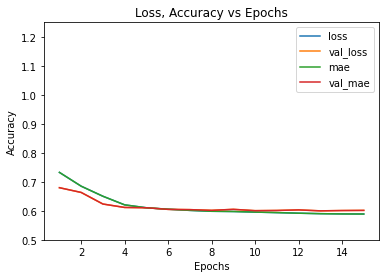

In [230]:
#plot the learning curves
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['mae'], label = 'mae')
plt.plot(epochs, history.history['val_mae'], label = 'val_mae')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#plt.xlim(20,100)
plt.ylim(0.5,1.25)
plt.legend()
plt.show()

In [370]:
# ทำการประเมิน model บน test set
mae = model.evaluate(Xtest, ytest)
print('test_mae:', mae[0])

81/81 [==============================] - 0s 2ms/step - loss: 0.5947 - mae: 0.5947
test_mae: 0.5946522355079651


In [371]:
pred1 = model.predict(Xtest)

81/81 [==============================] - 0s 3ms/step


In [372]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [415]:
pred1 = np.ndarray.flatten(np.reshape(pred1, (-1,len(pred1))))
# ค่า mae บน test set ก่อนการแปลง log(activity) กลับเป็น activity
print('test_mae:', mae(ytest, pred1))

test_mae: 0.5946520907423504


In [412]:
# แปลงค่าค่าก๊าซกัมมันตภาพรังสี Radon (activity) จาก log(activity) เป็น activity
pred1 = model.predict(Xtest)
pred1 = np.ndarray.flatten(np.reshape(pred1, (-1,len(pred1_exp))))
pred1_exp = np.exp(pred1)
ytest_exp = ytest.apply(np.exp)

81/81 [==============================] - 0s 2ms/step


In [413]:
# ทดลองทำนายค่าก๊าซกัมมันตภาพรังสี Radon ของตัวอย่างแรก
print("predict :", pred1_exp[0])
print("true y :", ytest_exp.iloc[0])

predict : 2.6895723
true y : 3.7000000476837163


In [416]:
pred1_exp = np.ndarray.flatten(np.reshape(pred1_exp, (-1,len(pred1_exp))))
print('test_mae:', mae(ytest_exp, pred1_exp))

test_mae: 2.549327077467656


## Tuning

In [50]:
tf.random.set_seed(46)

k = 4 # set the fold 
num_val_samples = len(X) // k
num_epochs = 200
batchsize = 16

all_train_scores = [] # optional
all_val_scores = []

all_loss_histories = []
all_val_loss_histories = []
all_mae_histories = []
all_val_mae_histories = []

for i in range(k):
  print('processing fold #', i+1)
  Xval = X[i * num_val_samples: (i + 1) * num_val_samples]
  yval = y[i * num_val_samples: (i + 1) * num_val_samples]
  
  #Prepares the training data: data from all other partitions
  partial_X = np.concatenate([X[:i * num_val_samples],X[(i + 1) * num_val_samples:]],axis=0)
  partial_y = np.concatenate([y[:i * num_val_samples],y[(i + 1) * num_val_samples:]],axis=0)
  
  # build the compiled model
  model = build_model()
  # train the model 
  history = model.fit(partial_X, partial_y, validation_data = (Xval,yval), epochs=num_epochs, batch_size=batchsize)
  
  # evaluates the model on the validation set เก็บ loss
  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)
  val_loss_history = history.history['val_loss']
  all_val_loss_histories.append(val_loss_history)
  mae_history = history.history['mae']
  all_mae_histories.append(mae_history)
  val_mae_history = history.history['val_mae']
  all_val_mae_histories.append(val_mae_history)

  val_loss, val_mae = model.evaluate(Xval, yval) # เก็บ val_loss 
  all_val_scores.append(val_mae)

  loss, mae = model.evaluate(partial_X, partial_y) # optional
  all_train_scores.append(mae) # optional

processing fold # 1
Epoch 1/200
590/590 [==============================] - 2s 3ms/step - loss: 0.7110 - mae: 0.7110 - val_loss: 0.6848 - val_mae: 0.6848
Epoch 2/200
590/590 [==============================] - 2s 3ms/step - loss: 0.6943 - mae: 0.6943 - val_loss: 0.6809 - val_mae: 0.6809
Epoch 3/200
590/590 [==============================] - 2s 3ms/step - loss: 0.6905 - mae: 0.6905 - val_loss: 0.6808 - val_mae: 0.6808
Epoch 4/200
590/590 [==============================] - 2s 3ms/step - loss: 0.6878 - mae: 0.6878 - val_loss: 0.6790 - val_mae: 0.6790
Epoch 5/200
590/590 [==============================] - 1s 3ms/step - loss: 0.6861 - mae: 0.6861 - val_loss: 0.6797 - val_mae: 0.6797
Epoch 6/200
590/590 [==============================] - 1s 2ms/step - loss: 0.6839 - mae: 0.6839 - val_loss: 0.6782 - val_mae: 0.6782
Epoch 7/200
590/590 [==============================] - 2s 3ms/step - loss: 0.6829 - mae: 0.6829 - val_loss: 0.6789 - val_mae: 0.6789
Epoch 8/200
590/590 [============================

In [54]:
# เปรียบเทียบค่า mae บน validaiton set กับ training set
print('----- on validation set -----')
print(all_val_scores)
print('average_val_loss: ', np.mean(all_val_scores))
print('----- on training set -----')
print(all_train_scores)
print('average_train_loss: ', np.mean(all_train_scores))

----- on validation set -----
[0.614378809928894, 0.7267326712608337, 0.705374538898468, 0.6094569563865662]
average_val_loss:  0.6639857441186905
----- on training set -----
[0.570875346660614, 0.6365998387336731, 0.6443082690238953, 0.5686711668968201]
average_train_loss:  0.6051136553287506


In [75]:
def build_model(n_layer, n_neurons, learning_rate, input_shape=(X.shape[1],)):
  model = keras.models.Sequential()
  options = {"input_shape": input_shape}
  for layer in range(n_layer):
    model.add(Dense(n_neurons, activation="relu", **options))
    options = {}
  model.add(Dense(1))
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  model.compile(loss="mae", optimizer=optimizer, metrics='mae')
  return model

In [76]:
import keras
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [77]:
import numpy as np
import scipy.stats as st
from sklearn.model_selection import GridSearchCV

param_distribs = {
    "n_layer": np.arange(1, 5, 1, dtype=int),
    "n_neurons": np.arange(60, 90, 10, dtype=int),
    "learning_rate": [0.01,0.001,0.0001]
}

grid_search_cv = GridSearchCV(keras_reg, param_distribs, cv=4)
grid_search_cv.fit(X, y, epochs=200, validation_data = (Xval,yval), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Streaming output truncated to the last 5000 lines.
Epoch 25/200
295/295 [==============================] - 2s 5ms/step - loss: 0.2969 - mae: 0.2969 - val_loss: 0.2884 - val_mae: 0.2884
Epoch 26/200
295/295 [==============================] - 2s 6ms/step - loss: 0.2918 - mae: 0.2918 - val_loss: 0.2830 - val_mae: 0.2830
Epoch 27/200
295/295 [==============================] - 2s 6ms/step - loss: 0.2871 - mae: 0.2871 - val_loss: 0.2770 - val_mae: 0.2770
Epoch 28/200
295/295 [==============================] - 2s 5ms/step - loss: 0.2816 - mae: 0.2816 - val_loss: 0.2729 - val_mae: 0.2729
Epoch 29/200
295/295 [==============================] - 2s 6ms/step - loss: 0.2776 - mae: 0.2776 - val_loss: 0.2702 - val_mae: 0.2702
Epoch 30/200
295/295 [==============================] - 2s 6ms/step - loss: 0.2732 - mae: 0.2732 - val_loss: 0.2636 - val_mae: 0.2636
Epoch 31/200
295/295 [==============================] - 2s 5ms/step - loss: 0.2693 - mae: 0.2693 - val_loss: 0.2675 - val_mae: 0.2675
Epoch 32/20

GridSearchCV(cv=4,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f8a78b65790>,
             param_grid={'learning_rate': [0.01, 0.001, 0.0001],
                         'n_layer': array([1, 2, 3, 4]),
                         'n_neurons': array([60, 70, 80])})

In [184]:
mse_test = grid_search_cv.score(Xtest, ytest)
mse_test

81/81 [==============================] - 0s 2ms/step - loss: 3.4035 - mae: 3.4035


-3.4034621715545654

In [185]:
grid_search_cv.best_params_

{'learning_rate': 0.001, 'n_layer': 3, 'n_neurons': 70}

In [80]:
print("Best: %f using %s" % (grid_search_cv.best_score_, grid_search_cv.best_params_))
means = grid_search_cv.cv_results_['mean_test_score']
stds = grid_search_cv.cv_results_['std_test_score']
params = grid_search_cv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.301061 using {'learning_rate': 0.001, 'n_layer': 3, 'n_neurons': 70}
-0.326666 (0.004979) with: {'learning_rate': 0.01, 'n_layer': 1, 'n_neurons': 60}
-0.334148 (0.007850) with: {'learning_rate': 0.01, 'n_layer': 1, 'n_neurons': 70}
-0.335697 (0.006826) with: {'learning_rate': 0.01, 'n_layer': 1, 'n_neurons': 80}
-0.309799 (0.005557) with: {'learning_rate': 0.01, 'n_layer': 2, 'n_neurons': 60}
-0.310772 (0.006622) with: {'learning_rate': 0.01, 'n_layer': 2, 'n_neurons': 70}
-0.309415 (0.004264) with: {'learning_rate': 0.01, 'n_layer': 2, 'n_neurons': 80}
-0.313285 (0.012076) with: {'learning_rate': 0.01, 'n_layer': 3, 'n_neurons': 60}
-0.314647 (0.009693) with: {'learning_rate': 0.01, 'n_layer': 3, 'n_neurons': 70}
-0.315998 (0.013169) with: {'learning_rate': 0.01, 'n_layer': 3, 'n_neurons': 80}
-0.310181 (0.006621) with: {'learning_rate': 0.01, 'n_layer': 4, 'n_neurons': 60}
-0.305201 (0.007202) with: {'learning_rate': 0.01, 'n_layer': 4, 'n_neurons': 70}
-0.309508 (0.012171)

In [404]:
pred2 = grid_search_cv.predict(Xtest)

81/81 [==============================] - 0s 2ms/step


In [418]:
pred2 = np.ndarray.flatten(np.reshape(pred2, (-1,len(pred2))))
# ค่า mae บน test set ก่อนการแปลง log(activity) กลับเป็น activity
print('test_mae:', mae(ytest, pred2))

test_mae: 0.17296093243428307


In [408]:
# แปลงค่า ค่าก๊าซกัมมันตภาพรังสี Radon (activity) จาก log(activity) เป็น activity
pred2 = grid_search_cv.predict(Xtest)
pred2 = np.ndarray.flatten(np.reshape(pred2, (-1,len(pred2_exp))))
pred2_exp = np.exp(pred2)

81/81 [==============================] - 0s 2ms/step


In [409]:
# ทดลองทำนายค่าก๊าซกัมมันตภาพรังสี Radon ของตัวอย่างแรก
print("predict :", pred2_exp[0])
print("true y :", ytest_exp.iloc[0])

predict : 3.2104385
true y : 3.7000000476837163


In [417]:
# ค่า mae บน test set หลังการแปลง log(activity) กลับเป็น activity
print('test_mae:', mae(ytest_exp, pred2_exp))

test_mae: 0.7852410086880313
